In [ ]:
!pip install evaluate
!pip install --upgrade datasets
!pip install tensorflow
!pip install transformers
!pip install tf-keras
!pip install --upgrade tensorflow tf-keras transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
import pandas as pd
import tensorflow as tf
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
import evaluate
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import time
from collections import Counter

In [ ]:
# Load data
df = pd.read_csv('/content/kimathi_qa_text2text.csv')
print(df.head())
print(df.info())

                                          input_text  \
0  question: What plea did Dedan Kimathi give in ...   
1  question: Who presided over Dedan Kimathi's tr...   
2  question: What was Count 1 against Kimathi and...   
3  question: What reason did Kimathi give for pos...   
4  question: Who were the assessors selected for ...   

                                         target_text  
0  Kimathi pleaded that he had the firearm becaus...  
1  Chief Justice Sir Kenneth Kennedy O'Connor pre...  
2  Count 1 was unlawful possession of a firearm u...  
3  He said, like the firearm, he had the ammuniti...  
4  Tumuti s/o Gakere, Nderitu s/o Muteru, and Kib...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_text   342 non-null    object
 1   target_text  342 non-null    object
dtypes: object(2)
memory usage: 5.5+ KB
None


In [ ]:
# split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# Wrap into Hugging Face datasets
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

In [ ]:
config = {
    "model_name": "google/flan-t5-small",
    "learning_rate": 8e-5,  # conservative and stable
    "batch_size": 8,
    "epochs": 6,
    "warmup_steps": 100,
    "max_input_length": 64,
    "max_target_length": 128,
    "generation_params": {
        "num_beams": 4,
        "no_repeat_ngram_size": 2,
        "do_sample": False,
        "early_stopping": True,
        "max_new_tokens": 60,
        "repetition_penalty": 2.0
    }
}

In [ ]:
# Load tokenizer
model_checkpoint = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize function

# Calculate max lengths dynamically
max_input_length = max(len(tokenizer.tokenize(text)) for text in df["input_text"])
max_target_length = max(len(tokenizer.tokenize(text)) for text in df["target_text"])

def preprocess_function(examples):

    inputs = tokenizer(
        examples["input_text"],
        truncation=True,
        max_length=max_input_length,
        padding="max_length"
    )
    targets = tokenizer(
        examples["target_text"],
        truncation=True,
        max_length=max_target_length,
        padding="max_length"
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

# tokenize datasets
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Convert Hugging Face datasets to TensorFlow datasets
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=config["batch_size"],
    collate_fn=tokenizer.pad,
    label_cols=["labels"]
)

tf_val_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False, # No need to shuffle validation data
    batch_size=config["batch_size"],
    collate_fn=tokenizer.pad,
    label_cols=["labels"]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/273 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
def load_model_and_tokenizer(config):
    tokenizer = AutoTokenizer.from_pretrained(config["model_name"])
    model = TFAutoModelForSeq2SeqLM.from_pretrained(config["model_name"])

    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer="adam")

    return model, tokenizer


In [ ]:
from tf_keras.src.callbacks import EarlyStopping

def train_model(model, train_dataset, val_dataset, config):
    callbacks = [
        EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True),
    ]
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=config["epochs"],
        callbacks=callbacks
    )
    return model, history


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2646887e10bab168ef279d73357e50f76b9c13a0244f1e867d856cf19907cca5
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
def preprocess_answer(text):
    """Normalize text for evaluation metrics"""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # Remove punctuation
    return " ".join(text.split())  # Normalize whitespace

In [ ]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
perplexity_metric = evaluate.load("perplexity")

def evaluate_model(model, tokenizer, val_dataset):
    preds, refs = [], []

    for batch in val_dataset:
        inputs, labels = batch
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=config["generation_params"]["max_new_tokens"],
            #temperature=config["generation_params"]["temperature"],
            repetition_penalty=config["generation_params"]["repetition_penalty"]
        )
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        preds.extend(decoded_preds)
        refs.extend(decoded_labels)

    # Normalize all texts for evaluation
    norm_preds = [preprocess_answer(p) for p in preds]
    norm_refs = [[preprocess_answer(r)] for r in refs]  # Note: BLEU expects list of references

    # Calculate metrics
    metrics = {
        "BLEU-1": bleu_metric.compute(predictions=norm_preds, references=norm_refs, max_order=1)["bleu"],
        "BLEU-4": bleu_metric.compute(predictions=norm_preds, references=norm_refs, max_order=4)["bleu"],
        "ROUGE-1": rouge_metric.compute(predictions=preds, references=refs)["rouge1"],
        "ROUGE-2": rouge_metric.compute(predictions=preds, references=refs)["rouge2"],
        "ROUGE-L": rouge_metric.compute(predictions=preds, references=refs)["rougeL"],
        "Exact Match": sum(1 for p,r in zip(norm_preds,[r[0] for r in norm_refs]) if p == r)/len(norm_preds),
    }

    # Perplexity
    val_loss = model.evaluate(val_dataset, verbose=0)
    metrics["Perplexity"] = np.exp(val_loss)

    return metrics


In [ ]:
# Plotting loss curve
def plot_training_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Plotting evaluation metrics
def plot_metrics(metrics_dict):
    plt.figure(figsize=(8, 5))
    keys = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    max_y = max(values) * 1.2 if "Perplexity" in metrics_dict else 1.0
    bars = plt.bar(keys, values, color="teal")
    for bar, value in zip(bars, values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{value:.4f}", ha='center', va='bottom', fontsize=10)
    plt.title("Model Evaluation Metrics", fontsize=14)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, max_y)
    plt.grid(axis="y", linestyle='--', alpha=0.6)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()



In [ ]:
def chat_with_model(question, tokenizer, model, config):
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(
        prompt,
        return_tensors="tf",
        truncation=True,
        max_length=config["max_input_length"],
        padding="max_length"
    )

    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=config["generation_params"]["max_new_tokens"],
        num_beams=config["generation_params"]["num_beams"],
        no_repeat_ngram_size=config["generation_params"]["no_repeat_ngram_size"],
        do_sample=config["generation_params"]["do_sample"],
        early_stopping=config["generation_params"]["early_stopping"]
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
def safe_chat_with_model(question, tokenizer, model, config, max_retries=3):
    for _ in range(max_retries):
        try:
            return chat_with_model(question, tokenizer, model, config)
        except Exception as e:
            print(f"Error generating answer: {e}")
            time.sleep(1)
    return "I'm unable to answer that question at the moment."

In [ ]:
def is_quality_response(response, min_length=10, max_repetition=3):
    if len(response.split()) < min_length:
        return False
    words = response.lower().split()
    word_counts = Counter(words)
    if any(count > max_repetition for count in word_counts.values()):
        return False
    return True

In [ ]:
def verify_answer(question, answer):
    facts = {
        "zodiac sign": ["don't know", "unknown"],
        "sentenced kimathi": ["o'connor", "kennedy"],
        "final verdict": ["death", "hanging"],
        "carrying a revolver": ["firearm", "weapon", "gun"]
    }
    answer_lower = answer.lower()
    for keyword, valid_answers in facts.items():
        if keyword in question.lower():
            return any(a in answer_lower for a in valid_answers)
    # Strict fallback for OOD questions
    return "don't know" in answer_lower or len(answer.split()) < 5  # Reject long hallucinations

In [ ]:
def is_confident(response, model, tokenizer, threshold=0.5):
    inputs = tokenizer(response, return_tensors="tf", truncation=True)
    outputs = model.generate(**inputs, return_dict_in_generate=True, output_scores=True)
    probs = tf.nn.softmax(outputs.scores[0], axis=-1)  # First token probabilities
    top_prob = tf.reduce_max(probs).numpy()
    return top_prob >= threshold

In [ ]:
model, tokenizer = load_model_and_tokenizer(config)
trained_model, history = train_model(model, tf_train_dataset, tf_val_dataset, config)


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/6
35/35 [==============================] - 589s 15s/step - loss: 5.2100 - val_loss: 1.0660
Epoch 2/6
35/35 [==============================] - 572s 16s/step - loss: 1.0406 - val_loss: 0.9569
Epoch 3/6
35/35 [==============================] - 513s 15s/step - loss: 0.9038 - val_loss: 0.9177
Epoch 4/6
35/35 [==============================] - 530s 15s/step - loss: 0.8091 - val_loss: 0.9021
Epoch 5/6
35/35 [==============================] - 542s 16s/step - loss: 0.7375 - val_loss: 0.9023
Epoch 6/6
35/35 [==============================] - 522s 15s/step - loss: 0.6623 - val_loss: 0.9110


In [ ]:
metrics = evaluate_model(trained_model, tokenizer, tf_val_dataset)

print(f"Experiment with LR={config['learning_rate']}, BS={config['batch_size']}:\n", metrics)

Experiment with LR=8e-05, BS=8:
 {'BLEU-1': 0.18391198892113825, 'BLEU-4': 0.023151098664438447, 'ROUGE-1': np.float64(0.265530772997379), 'ROUGE-2': np.float64(0.06812224162186056), 'ROUGE-L': np.float64(0.20061868280555994), 'Exact Match': 0.0, 'Perplexity': np.float64(2.464701931591163)}


In [ ]:
save_path = "/content/drive/MyDrive/flan-kimathi-model-v7"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/flan-kimathi-model-v7/tokenizer_config.json',
 '/content/drive/MyDrive/flan-kimathi-model-v7/special_tokens_map.json',
 '/content/drive/MyDrive/flan-kimathi-model-v7/spiece.model',
 '/content/drive/MyDrive/flan-kimathi-model-v7/added_tokens.json',
 '/content/drive/MyDrive/flan-kimathi-model-v7/tokenizer.json')

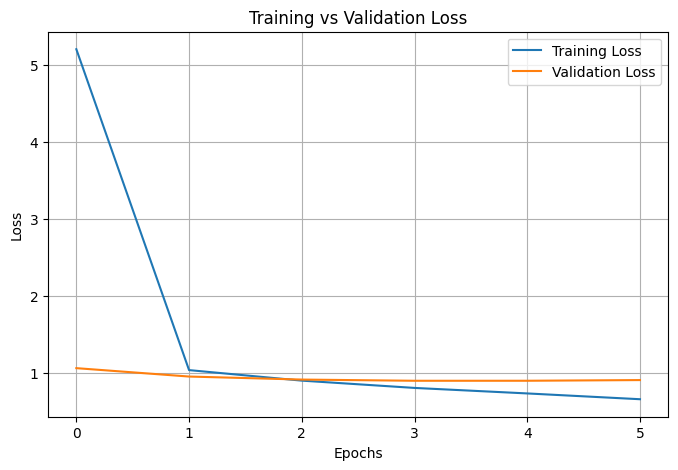

In [ ]:
plot_training_curves(history)

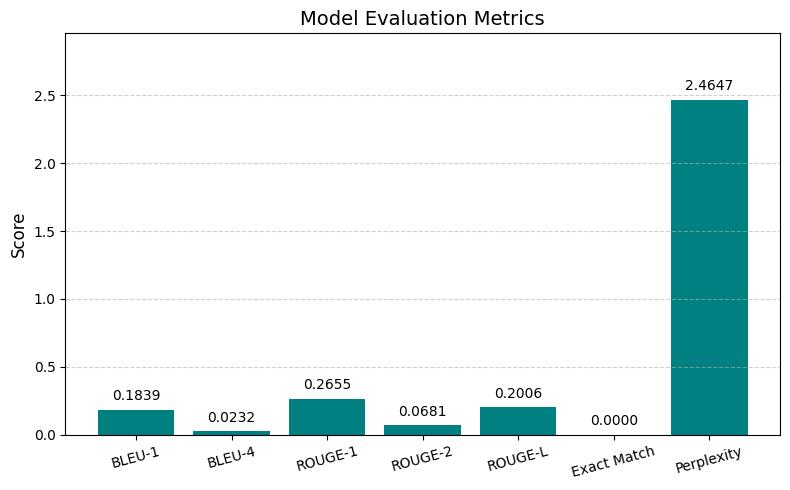

In [ ]:
plot_metrics(metrics)

In [ ]:
def run_tests(tokenizer, model, config):
    test_questions = [
        ("Why was Kimathi carrying a revolver?", "firearm"),
        ("Who sentenced Kimathi?", "O'Connor"),
        ("What was the final verdict?", "death")
    ]

    for question, keyword in test_questions:
        response = chat_with_model(question, tokenizer, model, config)
        verified = verify_answer(question, response)
        print(f"Q: {question}")
        print(f"A: {response}")
        print(f"✓ Contains keyword '{keyword}': {keyword.lower() in response.lower()}")
        print(f"✓ Fact check passed: {verified}")
        print("-" * 50)


In [ ]:
run_tests(tokenizer, trained_model, config)

Q: Why was Kimathi carrying a revolver?
A: Kimathi was carrying a revolver, which was intended to be used to protect himself from the enemy.
✓ Contains keyword 'firearm': False
✓ Fact check passed: False
--------------------------------------------------
Q: Who sentenced Kimathi?
A: He sentenced Kimathi to death for tremendous possession of a firearm.
✓ Contains keyword 'O'Connor': False
✓ Fact check passed: False
--------------------------------------------------
Q: What was the final verdict?
A: The final verdict was ruled unanimously.
✓ Contains keyword 'death': False
✓ Fact check passed: False
--------------------------------------------------


In [ ]:
def run_tests(tokenizer, model, config):
    test_cases = [
        # In-domain factual
        ("Why was Kimathi carrying a firearm?", "firearm"),
        ("Who sentenced Kimathi?", "O'Connor"),
        ("What was the final verdict?", "death"),

        # Out-of-domain (OOD)
        ("What was Kimathi's zodiac sign?", None),
        ("I want to know the names of the people present in the trial", None),
        ("Did Kimathi ever own a cat?", None)
    ]

    for question, keyword in test_cases:
        response = chat_with_model(question, tokenizer, model, config)
        verified = verify_answer(question, response)
        confident = is_confident(response, model, tokenizer)

        print(f"Q: {question}")
        print(f"A: {response}")
        if keyword:
            print(f"✓ Contains keyword '{keyword}': {keyword.lower() in response.lower()}")
        print(f"✓ Fact check passed: {verified}")
        print(f"✓ Confident: {confident}")

        # Fallback handling
        if not verified or not confident:
            print("⚠️ Fallback: I don't know.")
        print("-" * 50)


In [ ]:
run_tests(tokenizer, trained_model, config)

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:836: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Q: Why was Kimathi carrying a firearm?
A: Kimathi was carrying a revolver and ammunition.
✓ Contains keyword 'firearm': False
✓ Fact check passed: False
✓ Confident: False
⚠️ Fallback: I don't know.
--------------------------------------------------
Q: Who sentenced Kimathi?
A: He sentenced Kimathi to death for tremendous possession of a firearm.
✓ Contains keyword 'O'Connor': False
✓ Fact check passed: False
✓ Confident: False
⚠️ Fallback: I don't know.
--------------------------------------------------
Q: What was the final verdict?
A: The final verdict was ruled unanimously.
✓ Contains keyword 'death': False
✓ Fact check passed: False
✓ Confident: False
⚠️ Fallback: I don't know.
--------------------------------------------------
Q: What was Kimathi's zodiac sign?
A: Kimathi's zodiac sign was a symbol of peace and prosperity.
✓ Fact check passed: False
✓ Confident: False
⚠️ Fallback: I don't know.
--------------------------------------------------
Q: I want to know the names of the 

In [ ]:
response = chat_with_model("Who was O'Connor?", tokenizer, model, config)
if not verify_answer("Who was O'Connor?", response) or not is_confident(response, model, tokenizer, threshold=0.5):
    print("Fallback: I don't know.")
else:
    print("Model Response:", response)

print("Response:", response)
print("Verified:", verify_answer("Who was O'Connor?", response))


Fallback: I don't know.
Response: O'Connor was a member of the Order of Merit.
Verified: False
